In [11]:
import cvxpy as cp
import numpy as np
import time
import torch
import matplotlib.pyplot as plt
from zap.admm import ADMMSolver
from zap.conic.cone_bridge import ConeBridge
from zap.conic.cone_utils import generate_max_flow_problem, is_valid_network, get_standard_conic_problem


In [2]:
## Create a large problem that is valid 
n = 100
seed = 42
valid_source_sink_path = False

while (not valid_source_sink_path):
    problem, adj, inc = generate_max_flow_problem(n, seed)
    valid_source_sink_path = is_valid_network(adj)
    if (not valid_source_sink_path):
        seed += 1
nnz = float(adj.nnz)
total_possible_edges = float(adj.shape[0]*(adj.shape[0] - 1))
density = nnz/total_possible_edges
sparsity = 1 - density
num_variables = sum(np.prod(var.shape) for var in problem.variables())
num_constraints = sum(constraint.size for constraint in problem.constraints)
print(f'Generated a valid network with {n} nodes using seed {seed}')
print(f"Actual Number of Edges: {nnz}")
print(f"Total Possible Edges: {total_possible_edges}")
print(f"Graph sparsity: {sparsity}")
print(f"Graph density: {density}")
print(f"Number of Variables: {num_variables}")
print(f"Number of Constraints: {num_constraints}")

Generated a valid network with 100 nodes using seed 42
Actual Number of Edges: 932.0
Total Possible Edges: 9900.0
Graph sparsity: 0.9058585858585859
Graph density: 0.09414141414141414
Number of Variables: 932
Number of Constraints: 1032


In [3]:
# Get conic problem form so we can (i) solve standard conic form and (ii) solve using ZAP
cone_params, data, cones = get_standard_conic_problem(problem, solver=cp.CLARABEL)

In [26]:
# Solve the conic form using ZAP
machine = 'cpu'
dtype = torch.float32
cone_bridge = ConeBridge(cone_params)
cone_admm_devices = [d.torchify(machine=machine, dtype=dtype) for d in cone_bridge.devices]
cone_admm = ADMMSolver(
    machine=machine,
    dtype=dtype,
    atol=1e-6,
    rtol=1e-6,
    num_iterations=1000,
    eta=1e-4,
    # use_osgm=True,
)
start_time = time.time()
cone_solution_admm, cone_history_admm = cone_admm.solve(
    net=cone_bridge.net, devices=cone_admm_devices, time_horizon=cone_bridge.time_horizon
)
end_time = time.time()
solve_time = end_time - start_time
obj_val = cone_solution_admm.objective
print(f"Objective value: {obj_val}")
print(f"Time taken: {solve_time:.4f} seconds")



Did not converge. Ran for 1000 iterations.
Objective value: -90.34591674804688
Time taken: 0.2279 seconds


In [ ]:
# Compute residuals
power_history = np.array(cone_history_admm.power)
phase_history = np.array(cone_history_admm.phase)
dual_power_history = np.array(cone_history_admm.dual_power)
dual_phase_history = np.array(cone_history_admm.dual_phase)
primal_resid = np.sqrt(power_history ** 2 + phase_history ** 2)
dual_resid = np.sqrt(dual_power_history ** 2 + dual_phase_history ** 2)

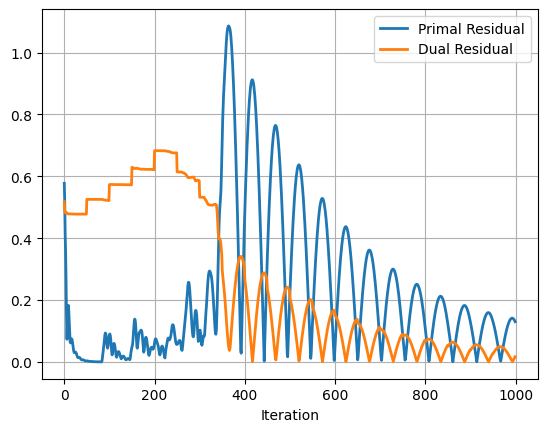

In [32]:
plt.figure()
plt.grid()
plt.plot(primal_resid, label='Primal Residual', linewidth=2)
plt.plot(dual_resid, label='Dual Residual', linewidth=2)
plt.xlabel('Iteration')
# plt.yscale('log')
plt.legend()